##Importing Datasets from Kaggle

In [1]:
!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

Dataset URL: https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images
License(s): ODbL-1.0
chest-ctscan-images.zip: Skipping, found more recently modified local copy (use --force to force download)


##Importing Libraries

In [2]:
import zipfile
import os
from glob import glob
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4, ResNet152V2, DenseNet121, EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.densenet import preprocess_input

## Data Preprocessing

### Merging dataset

In [3]:
!rm -rf dataset_preprocessed
!rm -rf dataset

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
# Create directories for each dataset
os.makedirs("dataset", exist_ok=True)

# Unzip files
with zipfile.ZipFile("chest-ctscan-images.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")


In [5]:
# Data directory
train_dir = "/kaggle/working/dataset/Data/train"
val_dir = "/kaggle/working/dataset/Data/valid"
test_dir = "/kaggle/working/dataset/Data/test"
categories = []

category_mapping = {
    "squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa": "squamous.cell.carcinoma",
    "adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib": "adenocarcinoma",
    "normal": "normal",
    "large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa": "large.cell.carcinoma",
}

# Rename folders
for old_category, new_category in category_mapping.items():
    old_path = os.path.join(train_dir, old_category)
    new_path = os.path.join(train_dir, new_category)

    # Rename if the folder exists
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed: {old_category} -> {new_category}")
    else:
        print(f"Folder not found: {old_category}")

for old_category, new_category in category_mapping.items():
    old_path = os.path.join(val_dir, old_category)
    new_path = os.path.join(val_dir, new_category)

    # Rename if the folder exists
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed: {old_category} -> {new_category}")
    else:
        print(f"Folder not found: {old_category}")


for category in os.listdir(train_dir):
    if os.path.isdir(os.path.join(train_dir, category)):
        categories.append(category)

test_cat = []
for category in os.listdir(test_dir):
    if os.path.isdir(os.path.join(test_dir, category)):
        test_cat.append(category)

Renamed: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa -> squamous.cell.carcinoma
Renamed: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib -> adenocarcinoma
Renamed: normal -> normal
Renamed: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa -> large.cell.carcinoma
Renamed: squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa -> squamous.cell.carcinoma
Renamed: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib -> adenocarcinoma
Renamed: normal -> normal
Renamed: large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa -> large.cell.carcinoma


In [6]:
print(categories)

['normal', 'adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma']


In [7]:
print(test_cat)

['normal', 'adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma']


In [8]:
total_images_train = 0
for category in categories:
    path = os.path.join(train_dir, category)
    total_images_train += len(os.listdir(path))
    print(f"{category}: {len(os.listdir(path))} images")
print(f"Total: {total_images_train} images")

total_images_val = 0
for category in categories:
    path = os.path.join(val_dir, category)
    total_images_val += len(os.listdir(path))
    print(f"{category}: {len(os.listdir(path))} images")
print(f"Total: {total_images_val} images")

total_images_test = 0
for category in categories:
    path = os.path.join(test_dir, category)
    total_images_test += len(os.listdir(path))
    print(f"{category}: {len(os.listdir(path))} images")
print(f"Total: {total_images_test} images")

normal: 148 images
adenocarcinoma: 195 images
large.cell.carcinoma: 115 images
squamous.cell.carcinoma: 155 images
Total: 613 images
normal: 13 images
adenocarcinoma: 23 images
large.cell.carcinoma: 21 images
squamous.cell.carcinoma: 15 images
Total: 72 images
normal: 54 images
adenocarcinoma: 120 images
large.cell.carcinoma: 51 images
squamous.cell.carcinoma: 90 images
Total: 315 images


In [9]:
IMG_SIZE = (224, 224)
# MAX_FEATURES = 300  # For SIFT feature extraction
BATCH_SIZE = 64
EPOCHS = 100
NUM_CLASSES = 4

# Replace these with your dataset directories
TRAIN_DIR = train_dir
VAL_DIR = val_dir
TEST_DIR = test_dir

In [10]:
def segment_lung(image_path):
    # Step 1: Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Step 2: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)
    
    # Step 3: Apply Gaussian Blur and Otsu's Thresholding
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, binary_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 4: Find contours and keep only the largest components (lungs)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary_mask)
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
    
    # Step 5: Remove noise with morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)  # Remove small artifacts
    
    # Step 6: Create a white background
    white_background = np.full_like(img, 255)  # White background (same size as the original)

    # Step 7: Extract lung regions and replace the rest with white
    lung_segment = cv2.bitwise_and(img, img, mask=mask_cleaned)  # Keep lungs
    result = white_background.copy()  # Start with a white image
    result[mask_cleaned > 0] = lung_segment[mask_cleaned > 0]  # Replace lung regions
    
    # Step 8: Resize for consistency (optional)
    result_resized = cv2.resize(result, (224, 224))
    
    return result_resized

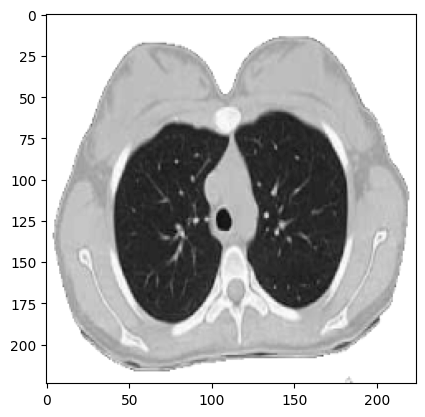

In [11]:
segmented_image = segment_lung("/kaggle/working/dataset/Data/train/normal/10.png")
plt.imshow(segmented_image, cmap='gray')

In [12]:
def refine_segment_lung(image_path):
    # Step 1: Read image in grayscale
    # img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = segment_lung(image_path)

    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))  # Adjust clipLimit and tile size as needed
    enhanced_img = clahe.apply(img)
    
    # Step 2: Apply Otsu's thresholding to create a binary mask
    blur = cv2.GaussianBlur(enhanced_img,(9,9),0)
    _, binary_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Step 3: Extract outer contours of the lung
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    draw = cv2.drawContours(binary_mask, contours, -1, 255, 3)
    
    # # Step 5: Apply the mask to the original grayscale image
    lung_segment = cv2.bitwise_not(binary_mask)
    
    white_background = np.full_like(enhanced_img, 255)  # Fill image with white pixels
    
    lung_segment2 = cv2.bitwise_and(enhanced_img, enhanced_img, mask=lung_segment)
    
    background_white = cv2.bitwise_not(white_background, white_background, mask=lung_segment2)

    result = background_white.copy()  # Start with a white image
    result[lung_segment > 0] = lung_segment2[lung_segment > 0]  # Replace lung regions
    
    # Resize for consistency
    result = cv2.resize(result, (224, 224))
    return result

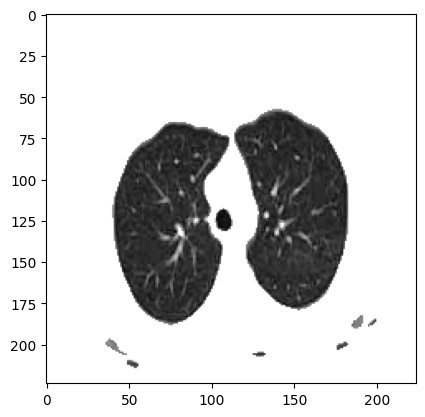

In [13]:
segmented_image = refine_segment_lung("/kaggle/working/dataset/Data/train/normal/10.png")
plt.imshow(segmented_image, cmap='gray')

In [14]:
def load_and_segment_images(directory, categories, num_samples=None):
    segmented_images = []
    labels = []

    for label, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        images_in_class = []

        # Load and segment all images in the category
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            # Segment the lung (replace with your function)
            segmented_img = refine_segment_lung(img_path)
            images_in_class.append(segmented_img)

        # Randomly sample a fixed number of images per class if specified
        if num_samples is not None:
            sampled_images = random.sample(images_in_class, min(num_samples, len(images_in_class)))
        else:
            sampled_images = images_in_class

        # Append the sampled images and labels
        segmented_images.extend(sampled_images)
        labels.extend([label] * len(sampled_images))

    return np.array(segmented_images), np.array(labels)

In [15]:
def augment_images(images, labels, augment_count=3):
    datagen = ImageDataGenerator(
        # zoom_range=0.1,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05
    )
    
    augmented_images = []
    augmented_labels = []
    
    for img, label in zip(images, labels):
        # Ensure the image has 4 dimensions (batch, height, width, channels)
        if len(img.shape) == 2:  # Grayscale images without channel dimension
            img = np.expand_dims(img, axis=-1)  # Add channel dimension
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        
        # Generate augmented images
        for _ in range(augment_count):
            for batch in datagen.flow(img, batch_size=1):
                augmented_images.append(batch[0].astype(np.uint8))  # Remove batch dimension and store image
                augmented_labels.append(label)
                break  # Stop after generating one augmented image per iteration
    
    return np.array(augmented_images), np.array(augmented_labels)

In [16]:
# Load and segment the training, validation, and test images
train_images, train_labels = load_and_segment_images(TRAIN_DIR, categories, num_samples=120)
val_images, val_labels = load_and_segment_images(VAL_DIR, categories)
test_images, test_labels = load_and_segment_images(TEST_DIR, categories, num_samples=50)

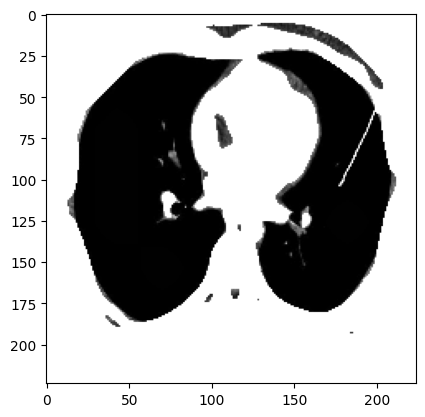

In [17]:
plt.imshow(train_images[50], cmap='gray')

In [18]:
# Augment the segmented images and labels (3 augmented images for each original image)
augmented_train_images, augmented_train_labels = augment_images(train_images, train_labels, augment_count=2)
augmented_val_images, augmented_val_labels = augment_images(val_images, val_labels, augment_count=1)
augmented_test_images, augmented_test_labels = augment_images(test_images, test_labels, augment_count=1)

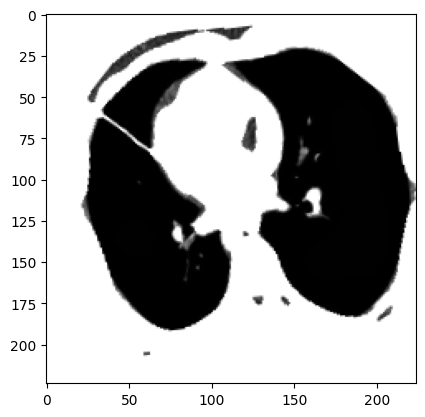

In [19]:
plt.imshow(augmented_train_images[10], cmap='gray')

In [20]:
# Confirm the shape of the datasets
print(f"Training data shape: {train_images.shape}")
print(f"Validation data shape: {val_images.shape}")
print(f"Test data shape: {test_images.shape}")

# Confirm the shape of the datasets
print(f"Augmented training data shape: {augmented_train_images.shape}")
print(f"Augmented Validation data shape: {augmented_val_images.shape}")
print(f"Augmented Test data shape: {augmented_test_images.shape}")

Training data shape: (475, 224, 224)
Validation data shape: (72, 224, 224)
Test data shape: (200, 224, 224)
Augmented training data shape: (950, 224, 224, 1)
Augmented Validation data shape: (72, 224, 224, 1)
Augmented Test data shape: (200, 224, 224, 1)


In [21]:
# Convert grayscale images to 3 channels (RGB)
augmented_train_rgb = np.repeat(augmented_train_images, 3, axis=-1)  # Shape: (N, 224, 224, 3)
augmented_val_rgb = np.repeat(augmented_val_images, 3, axis=-1)
augmented_test_rgb = np.repeat(augmented_test_images, 3, axis=-1)

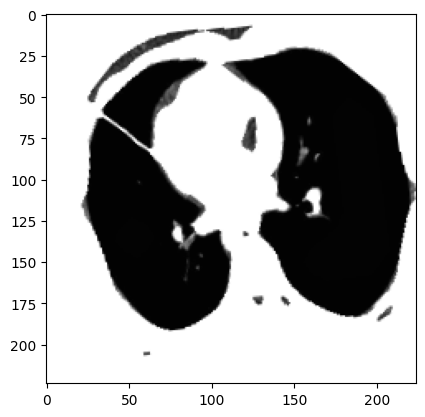

In [22]:
plt.imshow(augmented_train_rgb[10])

In [23]:
# Confirm the shape of the datasets
print(f"Augmented training data shape: {augmented_train_rgb.shape}")
print(f"Augmented Validation data shape: {augmented_val_rgb.shape}")
print(f"Augmented Test data shape: {augmented_test_rgb.shape}")

Augmented training data shape: (950, 224, 224, 3)
Augmented Validation data shape: (72, 224, 224, 3)
Augmented Test data shape: (200, 224, 224, 3)


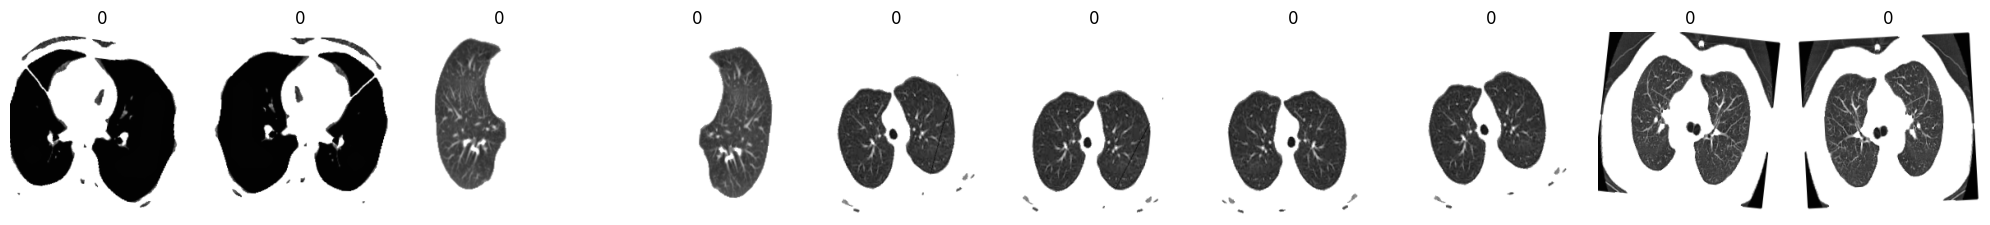

In [24]:
def plot_augmented_images(augmented_images, augmented_labels, num_samples=5):
    plt.figure(figsize=(20, 5))
    
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(augmented_images[i])
        plt.title(augmented_labels[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

plot_augmented_images(augmented_train_rgb, augmented_train_labels, num_samples=10)

In [25]:
def extract_orb_features(image):
    orb = cv2.ORB_create(
        nfeatures=25,          
    )
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if descriptors is None:
        descriptors = []
    return keypoints, descriptors


def extract_sift_features(image):
    sift = cv2.SIFT_create(
        nfeatures=20,          
    )
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is None:
        descriptors = []
    return keypoints, descriptors

def adjust_keypoint_size(keypoints, scale_factor):
    for kp in keypoints:
        kp.size *= scale_factor  # Scale the keypoint size
    return keypoints

def feature_extraction_function(img):
    # Extract ORB and SIFT features
    orb_keypoints, _ = extract_orb_features(img)
    orb_keypoints = adjust_keypoint_size(orb_keypoints, scale_factor=0.1)
    
    sift_keypoints, _ = extract_sift_features(img)
    sift_keypoints = adjust_keypoint_size(sift_keypoints, scale_factor=0.1)

    # Draw keypoints on the Sobel-filtered image
    img_with_keypoints = cv2.drawKeypoints(
        img, orb_keypoints, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)
    img_with_keypoints = cv2.drawKeypoints(
        img_with_keypoints, sift_keypoints, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)

    return img_with_keypoints

In [26]:
def process_dataset(dataset, dataset_name, show_samples=False):
    processed_images = []
    print(f"Processing {dataset_name}...")

    for idx, image in enumerate(dataset):
        # Ensure image is in the proper format (convert to uint8 if necessary)
        image = np.uint8(image)
        
        # Apply the feature extraction function
        processed_img = feature_extraction_function(image)
        processed_images.append(processed_img)
        
        # Optional: Display some sample images
        if show_samples and idx < 3:  # Show first 3 images
            plt.imshow(processed_img, cmap="gray")
            plt.title(f"{dataset_name} Sample {idx + 1}")
            plt.axis('off')
            plt.show()

    print(f"{dataset_name} processing complete: {len(processed_images)} images processed.")
    return np.array(processed_images)

Processing Training Data...


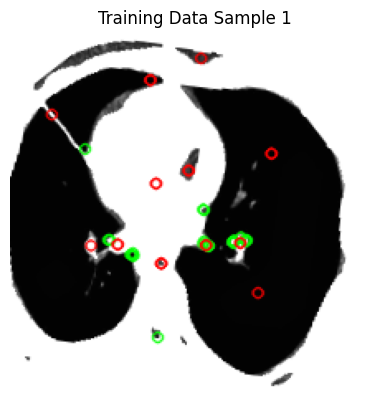

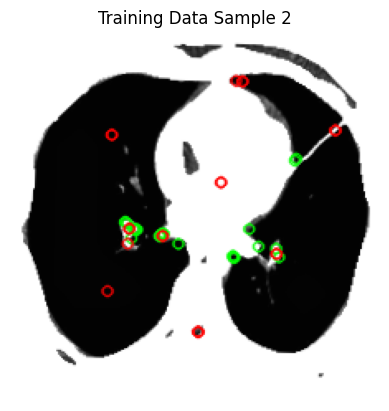

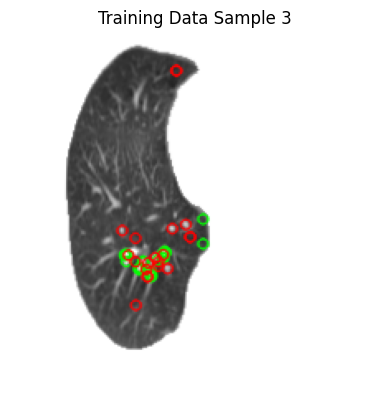

Training Data processing complete: 950 images processed.
Processing Validation Data...
Validation Data processing complete: 72 images processed.
Processing Test Data...
Test Data processing complete: 200 images processed.
Train images shape: (950, 224, 224, 3), dtype: float32
Validation images shape: (72, 224, 224, 3), dtype: float32
Test images shape: (200, 224, 224, 3), dtype: float32


In [27]:
processed_train= process_dataset(augmented_train_rgb, "Training Data", show_samples=True)
processed_val= process_dataset(augmented_val_rgb, "Validation Data", show_samples=False)
processed_test= process_dataset(augmented_test_rgb, "Test Data", show_samples=False)

# Normalize the images: Convert to float32 and scale to [0, 1]
augmented_train_rgb = preprocess_input(processed_train)
augmented_val_rgb = preprocess_input(processed_val)
augmented_test_rgb = preprocess_input(processed_test)

# # Normalize the images: Convert to float32 and scale to [0, 1]
# augmented_train_rgb = preprocess_input(augmented_train_rgb)
# augmented_val_rgb = preprocess_input(augmented_val_rgb)
# augmented_test_rgb = preprocess_input(augmented_test_rgb)

# Check shapes and types
print(f"Train images shape: {augmented_train_rgb.shape}, dtype: {augmented_train_rgb.dtype}")
print(f"Validation images shape: {augmented_val_rgb.shape}, dtype: {augmented_val_rgb.dtype}")
print(f"Test images shape: {augmented_test_rgb.shape}, dtype: {augmented_test_rgb.dtype}")

In [28]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(augmented_train_labels),
    y=augmented_train_labels
)

class_weights = dict(enumerate(class_weights))  # Convert to dictionary
print("Class Weights:", class_weights)

Class Weights: {0: 0.9895833333333334, 1: 0.9895833333333334, 2: 1.0326086956521738, 3: 0.9895833333333334}


In [29]:
from tensorflow.keras.applications import DenseNet201
image_input = Input(shape=(224, 224, 3), name="image_input")

# Load the DenseNet201 model with ImageNet weights (pre-trained)
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3), input_tensor=image_input)

# Freeze the convolutional base layers so they are not trained
base_model.trainable = False

# Add custom classifier on top of the DenseNet201 base model
x = base_model(image_input)
x = GlobalAveragePooling2D()(x)  # Global Average Pooling layer
# x = BatchNormalization()(x)
# x = Dense(512, activation='relu')(x)  # Fully connected layer
# x = Dropout(0.5)(x)  # Dropout layer to avoid overfitting
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout layer to avoid overfitting
x = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer with softmax for classification

# Define the full model
model = Model(inputs=image_input, outputs=x)

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# One-hot encode the labels
augmented_train_labels = to_categorical(augmented_train_labels, num_classes=NUM_CLASSES)
augmented_val_labels = to_categorical(augmented_val_labels, num_classes=NUM_CLASSES)
augmented_test_labels = to_categorical(augmented_test_labels, num_classes=NUM_CLASSES)

In [31]:
# Show the model summary to confirm architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1920)           │         7,680 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,822,468 (71.80 MB)

 Trainable params: 496,644 (1.89 MB)

 Non-trainable params: 18,325,824 (69.91 MB)

In [32]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint("_model_segmented.keras", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

In [33]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False
# Train the model with the augmented data
history = model.fit(augmented_train_rgb, 
                    augmented_train_labels, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    class_weight=class_weights,
                    validation_data=(augmented_val_rgb, augmented_val_labels),
                    callbacks=callbacks)

Epoch 1/100


I0000 00:00:1734450164.262540   13173 service.cc:145] XLA service 0x7c35f0011490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734450164.262585   13173 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734450164.262589   13173 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734450199.319909   13173 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.5181 - loss: 1.2578 - val_accuracy: 0.4861 - val_loss: 1.6077 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.8992 - loss: 0.2857 - val_accuracy: 0.5000 - val_loss: 2.0033 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 376ms/step - accuracy: 0.9622 - loss: 0.1283 - val_accuracy: 0.5972 - val_loss: 1.2654 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.9854 - loss: 0.0497 - val_accuracy: 0.5833 - val_loss: 1.3991 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 402ms/step - accuracy: 0.9989 - loss: 0.0238 - val_accuracy: 0.6667 - val_loss: 1.1076 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.9959 - loss: 0.0137 - val_accuracy: 0.6667 - val_loss: 1.1701 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.9977 - loss: 0.0155 - val_ac

In [34]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(augmented_test_rgb, augmented_test_labels)

print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.8346 - loss: 0.4070
Test accuracy: 0.7549999952316284
Test loss: 0.5985230207443237


7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step 


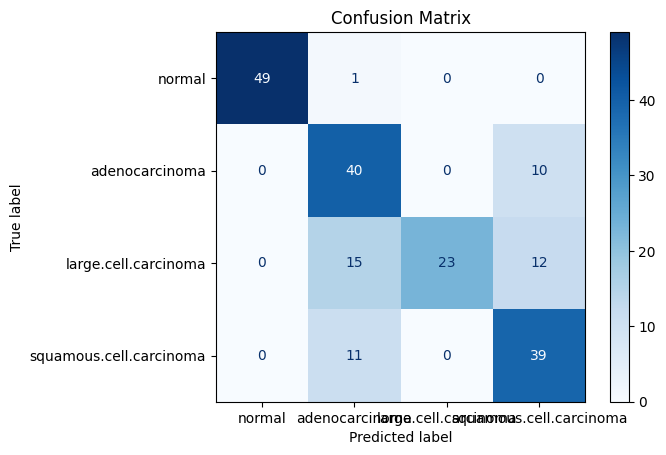

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the validation set
test_predictions = model.predict(augmented_test_rgb)
test_pred_classes = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels
test_true_classes = np.argmax(augmented_test_labels, axis=1)  # True class labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [36]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(test_true_classes, test_pred_classes, target_names=categories)
print("Classification Report:")
print(report)

Classification Report:
                         precision    recall  f1-score   support

                 normal       1.00      0.98      0.99        50
         adenocarcinoma       0.60      0.80      0.68        50
   large.cell.carcinoma       1.00      0.46      0.63        50
squamous.cell.carcinoma       0.64      0.78      0.70        50

               accuracy                           0.76       200
              macro avg       0.81      0.76      0.75       200
           weighted avg       0.81      0.76      0.75       200

